# NYC Taxi Analytics with Apache Spark
**Team Members**
- Andrea Cantu Magallanes  
- Tatiana Lebedeva  
- Maria Usikova  
- Lorena Torres Jimenez

# Initialization of Spark Session and Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

spark = SparkSession.builder.master('local[3]').appName("AverageSpeedFullAPI").getOrCreate()
sc = spark.sparkContext

# Study 1 - Average Taxi Speed by Hour
In this study we compute the average taxi speed (mph) for each hour of the day, using RDD and DataFrame methods.<br>
After completing this we state execution time and amount of data processed.<br>
Additionally, we measure speed-up by increasing the number of cores and then report scalability.

## Load the dataset
Reading the January 2025 Yellow Taxi dataset from Parquet format, inferring schema and parsing timestamps automatically.

In [2]:
def read_parquet(spark):
      return (spark.read.format("parquet")
            .option("inferSchema", "true")
            .option("timestampFormat","yyyy-MM-dd HH:mm:ss")
            .option("header", "true")
            .option("mode", "DROPMALFORMED")
            .load("yellow_tripdata_2025-01.parquet"))

df = read_parquet(spark)
print("Total records:", df.count())
df.printSchema()

Total records: 3475226
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



## Data cleaning
We clean the data by removing null values and outliers.<br>
We have defined the following constrains:
- Distance must be less than 1000 miles
- Fare amount must be more than zero and less than 1000 dollars
- Both fare and tip amounts cannot be negative  
- Pickup and dropoff timestamps must differ
- Passenger count must be more than zero



In [3]:
def clean_data(df):
    return df.na.drop().where(
        "trip_distance < 1000 and fare_amount < 1000 and tip_amount >= 0 and fare_amount > 0 and tpep_pickup_datetime != tpep_dropoff_datetime and passenger_count > 0"
    )
    
clean = clean_data(df)
print(f"Cleaned records: {clean.count():,}")
clean.limit(5).toPandas()

Cleaned records: 2,848,193


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1,1.60,1,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1,0.50,1,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1,0.60,1,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3,0.52,1,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3,0.66,1,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0,0.0


## Convert to timestamp columns
Converting pickup and dropoff times into a timestamp format.



In [4]:
def timestamp(df):
      return (df
            .withColumn("tpep_pickup_timestamp",  F.to_timestamp(F.col("tpep_pickup_datetime")))
            .withColumn("tpep_dropoff_timestamp", F.to_timestamp(F.col("tpep_dropoff_datetime"))))

ts = timestamp(clean)

## Computation of speed and trip duration
To compute trip duration (in hours) and speed (in mph) we use the **RDD API**.



In [5]:
def calculate_speed(row):
    pu = row['tpep_pickup_timestamp']
    do = row['tpep_dropoff_timestamp']
    dist = row['trip_distance']
    if not pu or not do or dist is None:
        return None
    try:
        dur = (do.timestamp() - pu.timestamp()) / 3600.0
        if dur > 0:
            spd = dist / dur
            if 0 < spd < 100:
                return (pu.hour, spd)
    except:
        return None
    return None

def calculate_speed_rdd(df):
    return df.select("tpep_pickup_timestamp","tpep_dropoff_timestamp","trip_distance").rdd.map(calculate_speed).filter(lambda x: x is not None)

rdd_speed = calculate_speed_rdd(ts)
speed_df = spark.createDataFrame(rdd_speed, ["hour","speed_mph"])
speed_df.show(5)

+----+------------------+
|hour|         speed_mph|
+----+------------------+
|   0|11.497005988023954|
|   0| 11.76470588235294|
|   0| 18.46153846153846|
|   0| 5.604790419161676|
|   0|11.207547169811322|
+----+------------------+
only showing top 5 rows


## Computation of average speed per hour
To group and compute the average speed per hour we use the **DataFrame API**.


In [6]:
def compute_average_speed(df):
    return (df.groupBy("hour")
        .agg(
            F.avg("speed_mph").alias("avg_speed_mph"),
            F.count("*").alias("n_trips")
        )
        .orderBy("hour"))

df_group = compute_average_speed(speed_df)
df_group.show(24)

+----+------------------+-------+
|hour|     avg_speed_mph|n_trips|
+----+------------------+-------+
|   0|14.724481739169363|  65095|
|   1|14.065524058018662|  43656|
|   2|13.948625023670683|  29448|
|   3|14.913260458948665|  19138|
|   4| 17.96483203715933|  12322|
|   5|19.360163017369583|  15368|
|   6| 15.67854740627952|  34860|
|   7|12.725145342420284|  74095|
|   8| 10.84254998330916| 105777|
|   9|10.741347378149905| 122145|
|  10|10.684094416138782| 133518|
|  11|10.192189832685328| 144561|
|  12|10.243440511284033| 157010|
|  13| 10.21080301177947| 165861|
|  14|10.062851230841154| 178702|
|  15| 9.957032795989264| 188085|
|  16| 10.10292117851467| 190623|
|  17| 9.805798739106201| 206853|
|  18|10.175139774706013| 205833|
|  19|11.452380772288613| 174538|
|  20|12.541128368839875| 157821|
|  21|12.812119275415945| 161432|
|  22|13.048563700612778| 134078|
|  23|14.478565184493933|  94291|
+----+------------------+-------+



## Visualization
Plot of the average speed by hour to identify traffic patterns.


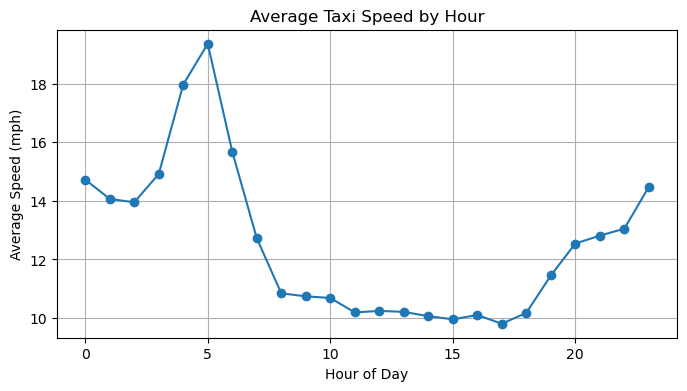

In [7]:
pdf = df_group.toPandas()

plt.figure(figsize=(8,4))
plt.plot(pdf["hour"], pdf["avg_speed_mph"], marker='o', color='tab:blue')
plt.title("Average Taxi Speed by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Speed (mph)")
plt.grid(True)
plt.show()

### Interpretation of Results
The hourly speed pattern clearly reflects real-world traffic behavior in New York City:
- Highest speeds (4-6 AM) occur when traffic is minimal.
- Lowest speeds (8 AM-5 PM) coincide with morning and afternoon congestion.
- The overall trend confirms that the Spark-based computation captures genuine temporal traffic dynamics.

This validates the correctness of the data cleaning and time-based aggregation process.


## Scalability study (Amdahl's Law)
To compare the real speed up with theoretical we measure execution time with different the number of cores,<br>
 and then compare it with the theoretical speed-up predicted by Amdahl's Law.


In [8]:
def stop_session():
    for _ in range(5):
        if SparkContext._active_spark_context:
            SparkContext._active_spark_context.stop()
            time.sleep(2)
        else:
            break

def measure_execution(cores):
    # Start new Spark session with variable number of cores
    spark = SparkSession.builder.master(f"local[{cores}]").appName(f"AvgSpeed-{cores}cores").getOrCreate()
    
    start_time = time.time()

    df = read_parquet(spark)
    clean = clean_data(df)
    ts = timestamp(clean)
    speed_df = spark.createDataFrame(calculate_speed_rdd(ts), ["hour","speed_mph"])
    df_group = compute_average_speed(speed_df)

    duration = time.time() - start_time

    stop_session()
    return duration

print(f"Amount of records processed {speed_df.count():,}")
stop_session()
# Run for different number of cores
cores_list = [1, 3, 4, 6]
times_measured = [measure_execution(c) for c in cores_list]
speedups_real = [times_measured[0] / t for t in times_measured]

# Display results
for c, t, s in zip(cores_list, times_measured, speedups_real):
    print(f"{c} cores -> Execution time {t:.2f} seconds -> speed-up {s:.2f}x")

Amount of records processed 2,815,110
1 cores -> Execution time 7.17 seconds -> speed-up 1.00x
3 cores -> Execution time 3.01 seconds -> speed-up 2.38x
4 cores -> Execution time 3.18 seconds -> speed-up 2.25x
6 cores -> Execution time 3.32 seconds -> speed-up 2.16x


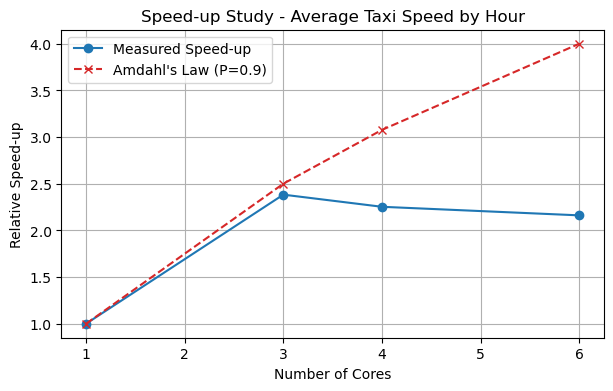

In [9]:
P = 0.9  
cores = np.array(cores_list)

speedups_theoretical = 1 / ((1 - P) + (P / cores))

# Plot comparison
plt.figure(figsize=(7, 4))
plt.plot(cores, speedups_real, 'o-', label="Measured Speed-up", color='tab:blue')
plt.plot(cores, speedups_theoretical, 'x--', label=f"Amdahl's Law (P={P})", color='tab:red')
plt.xlabel("Number of Cores")
plt.ylabel("Relative Speed-up")
plt.title("Speed-up Study - Average Taxi Speed by Hour")
plt.legend()
plt.grid(True)
plt.show()

# Discussion and Conclusions

| Metric | Value |
|--------|--------|
| Records processed | 2.8 million |
| Execution time (3 cores) | 3.01 seconds |
| Max speed-up | 2.38x |

### Spark APIs used:
- RDD API: custom speed computation (`.rdd.map(calculate_speed)`)  
- DataFrame API: data cleaning, timestamp conversion, and grouping  

### Performance
The complete Spark workflow demonstrated stable and efficient execution with an average time of around 3 seconds when processing nearly 2.8 million records.

### Scalability and interpretation
Although Spark scales well in distributed environments, the measured speed-up in this study was modest (2.38x).  
Performance improves when increasing from 1 to 3 cores, but between 3 and 4 cores the gain decreases. This is an indication of diminishing returns caused by synchronization and task scheduling overhead.  
This plateau effect suggests that the workload is partially parallelizable, and that the benefits of additional cores are limited by I/O operations and the non-parallel fraction of the code.  
The results therefore remain consistent with Amdahl's Law (P = 0.9), confirming that most of the computation benefits come from the parallel portion but are quickly bounded by serial dependencies.
While the absolute execution times remain low, the experiment shows that speed-up gains are not always linear and may even decrease with more cores, especially for data aggregation tasks where coordination costs dominate.

# Study 2 - Most Common Taxi Trips (DataFrame API only)

**Goal.** Identify the most frequent origin–destination taxi trips (by `PULocationID`, `DOLocationID`)  
using the Spark DataFrame.

**Deliverables.**
- Top trips table (counts)
- Execution time and amount of data processed

## Initialization of Spark Session

In [10]:
spark = SparkSession.builder.master("local[3]").appName("AverageSpeedFullAPI").getOrCreate()

## Load and Clean Dataset
We load the January 2025 yellow taxi dataset from Parquet format and remove invalid records.


In [11]:
df = read_parquet(spark)

clean = clean_data(df)

## Aggregation with DataFrame API
Group by `PULocationID` and `DOLocationID` to count trip frequency, sort descending and take the top number.


In [12]:
def find_top_trip(df, top_number):
    top_trips_df = (df.groupBy("PULocationID", "DOLocationID").count().orderBy(F.desc("count")))
    top_n = top_trips_df.limit(top_number).collect()
    return top_trips_df, top_n

top_number = 15
top_trips_df, top_rows = find_top_trip(clean, top_number)

print(f"\nTop {top_number} Most Common Trips (PU -> DO):")
for r in top_rows:
    print(f"{r['PULocationID']:>3} -> {r['DOLocationID']:>3} : {r['count']:,}")


Top 15 Most Common Trips (PU -> DO):
237 -> 236 : 23,486
236 -> 237 : 20,285
236 -> 236 : 16,853
237 -> 237 : 16,139
161 -> 237 : 10,725
237 -> 161 : 9,379
161 -> 236 : 9,157
239 -> 238 : 8,902
142 -> 239 : 8,579
239 -> 142 : 8,069
141 -> 236 : 8,014
186 -> 230 : 7,947
236 -> 141 : 7,460
237 -> 141 : 7,332
237 -> 162 : 7,323


## Join with Taxi Zones and Name Routes
Compute what percentage of all records the top number of routes represent, also using csv to identify the most common trips .


In [13]:

zones_pd = pd.read_csv("taxi_zone_lookup.csv")
zones = spark.createDataFrame(zones_pd)

zones_pu = zones.select(
    F.col("LocationID").alias("PULocationID"),
    F.col("Zone").alias("PUZone")
)

zones_do = zones.select(
    F.col("LocationID").alias("DOLocationID"),
    F.col("Zone").alias("DOZone")
)

top_named = (
    top_trips_df
    .join(zones_pu, on="PULocationID", how="left")
    .join(zones_do, on="DOLocationID", how="left")
    .select("PUZone", "DOZone", "count")
    .orderBy(F.desc("count"))
)

top_named.show(10, truncate=False)

+---------------------+---------------------+-----+
|PUZone               |DOZone               |count|
+---------------------+---------------------+-----+
|Upper East Side South|Upper East Side North|23486|
|Upper East Side North|Upper East Side South|20285|
|Upper East Side North|Upper East Side North|16853|
|Upper East Side South|Upper East Side South|16139|
|Midtown Center       |Upper East Side South|10725|
|Upper East Side South|Midtown Center       |9379 |
|Midtown Center       |Upper East Side North|9157 |
|Upper West Side South|Upper West Side North|8902 |
|Lincoln Square East  |Upper West Side South|8579 |
|Upper West Side South|Lincoln Square East  |8069 |
+---------------------+---------------------+-----+
only showing top 10 rows


## Visualization (Top 10 Routes)
Bar chart showing the top number of pickup-dropoff pairs by number of trips.


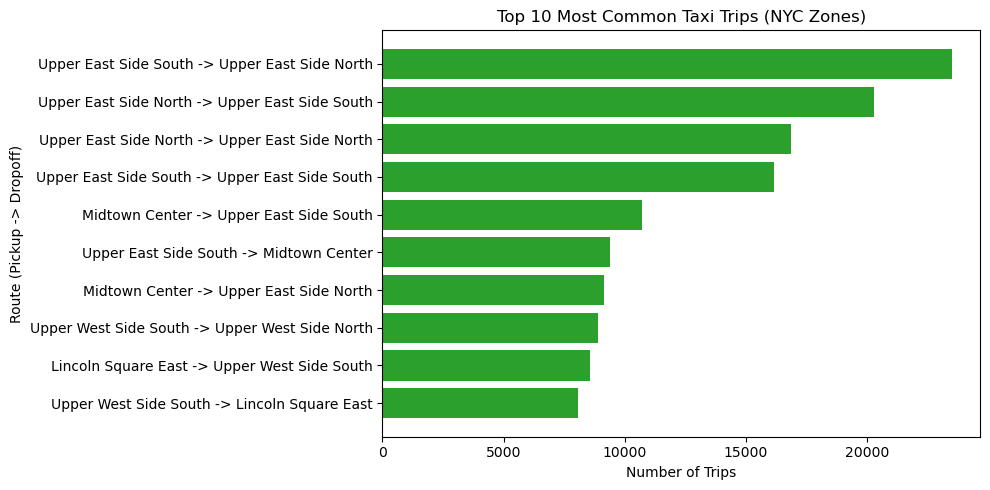

In [14]:

top_named_pd = top_named.limit(10).toPandas()
top_named_pd["route"] = top_named_pd["PUZone"] + " -> " + top_named_pd["DOZone"]

plt.figure(figsize=(10, 5))
plt.barh(top_named_pd["route"], top_named_pd["count"], color="tab:green")
plt.title("Top 10 Most Common Taxi Trips (NYC Zones)")
plt.xlabel("Number of Trips")
plt.ylabel("Route (Pickup -> Dropoff)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Interpretation of Results

The bar chart shows the **top 10 most common NYC taxi routes**, mainly concentrated in Manhattan:

- **Upper East Side South ↔ Upper East Side North** are the most frequent trips, indicating strong **local mobility** within the area.  
- Routes connecting **Midtown Center** and **Upper East Side** highlight **commuting patterns** between residential and business zones.  
- **Upper West Side** and **Lincoln Square** routes also appear, showing **consistent demand** in western Manhattan.

Overall, taxi activity is **highly concentrated in central Manhattan**, confirming that the **Spark aggregation** accurately reflects real traffic flows.


## Execution Speed-up Study (Amdahl's Law)
Measuring execution time using 1–4 cores and comparing the observed speed-up to Amdahl's Law (P = 0.9).


In [15]:
def measure_execution_trips(cores):
    spark = (SparkSession.builder.master(f"local[{cores}]").appName(f"AverageSpeedFullAPI-with-{cores}cores").getOrCreate())
    
    start_time = time.time()

    df = read_parquet(spark)
    clean = clean_data(df)
    find_top_trip(clean, 10)
    
    duration = time.time() - start_time
    
    stop_session()
    return duration

print(f"Data processed: {clean.count():,} rows")
stop_session()
# Test scalability across multiple cores
cores_list = [1, 3, 4, 6]
times = [measure_execution_trips(c) for c in cores_list]
speedups = [times[0] / t for t in times]

# Display measured results
print("Execution Time and Speed-up by Number of Cores\n")
for c, t, s in zip(cores_list, times, speedups):
    print(f"{c} cores -> {t:.2f} seconds -> speed-up {s:.2f}x")


Data processed: 2,848,193 rows
Execution Time and Speed-up by Number of Cores

1 cores -> 1.49 seconds -> speed-up 1.00x
3 cores -> 1.18 seconds -> speed-up 1.26x
4 cores -> 1.17 seconds -> speed-up 1.28x
6 cores -> 1.22 seconds -> speed-up 1.22x


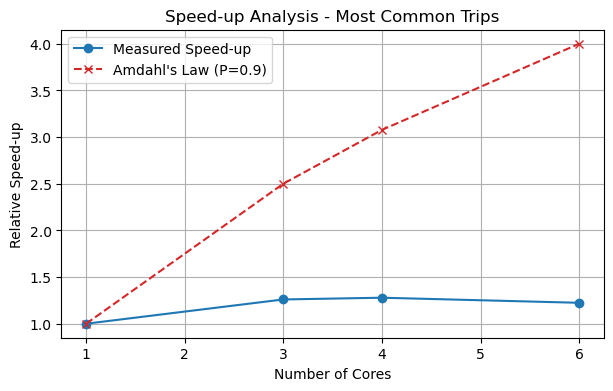

In [16]:
P = 0.9
cores = np.array(cores_list)
theoretical = 1 / ((1 - P) + (P / cores))

# Plot comparison
plt.figure(figsize=(7,4))
plt.plot(cores, speedups, 'o-', label="Measured Speed-up", color='tab:blue')
plt.plot(cores, theoretical, 'x--', label=f"Amdahl's Law (P={P})", color='tab:red')
plt.title("Speed-up Analysis - Most Common Trips")
plt.xlabel("Number of Cores")
plt.ylabel("Relative Speed-up")
plt.legend()
plt.grid(True)
plt.show()

## Discussion and Final Interpretation

| Metric | Value |
|---------|--------|
| Execution time (3 cores) | 1–2 s |
| Records processed | 2.8 million |
| Max speed-up | 1.28x |

### Performance
The DataFrame API in Spark achieved stable and efficient performance, benefiting from its high-level abstraction and advanced optimization engines.  
Processing nearly 2.8 million records in around 1–2 seconds confirms the robustness of these internal optimizations.  

Although a speed-up of 1.28x is observed when increasing from 1 to 4 cores, it is not statistically significant. This limited improvement is expected for I/O-bound workloads, where performance is mainly constrained by data transfer and aggregation overhead rather than raw CPU computation.  
Still, the results validate that Spark's DataFrame execution model maintains consistency, optimization, and predictable behavior even under parallel load.

Overall, the DataFrame API provides a strong balance between performance, scalability, and usability, demonstrating why it is the preferred choice for structured data analytics in Spark.

### Scalability and interpretation
The workload exhibits partial parallelization (P = 0.9).  
Beyond 4 cores, the performance gain flattens - consistent with Amdahl's Law - as synchronization and communication costs start to dominate.  
This plateau behavior reflects Spark's internal scheduling efficiency and shows that additional performance gains would require cluster-level scaling or caching strategies rather than more cores.
The DataFrame-based implementation successfully identified the top 10 most frequent taxi routes in New York City, revealing strong local mobility patterns within Upper East Side and Midtown zones.  
These results confirm the accuracy of the aggregation logic and demonstrate the effectiveness of Spark DataFrames in managing and analyzing large-scale structured datasets.

# Study 3 - Financial Records (Tips & Fares)

**Goal.** Identify which of the three Spark implementations - **RDD, DataFrame, and SQL** - is the fastest and most efficient for analyzing financial performance in taxi trips.

The study compares execution time, scalability, and data processing efficiency across these APIs when computing total fares, tips, and average tip rates.

**Deliverables.**
- Financial analysis using RDD, DataFrame and SQL using total fares, total tips, average values, tip rate
- Graph showing average revenue per trip per hour
- Execution time for each implementation and their comparison

## Initialization of Spark Session

In [17]:
spark = (SparkSession.builder.master("local[3]").appName("AverageSpeedFullAPI").getOrCreate())

## Load and Clean Dataset
We load the January 2025 yellow taxi dataset from Parquet format and remove invalid records.


In [18]:
df =  read_parquet(spark)

clean = clean_data(df).withColumn("hour", F.hour("tpep_pickup_datetime")).select("hour", "fare_amount", "tip_amount", "passenger_count")

## Financial Analysis using RDD

Computation of total revenue (`total_revenue`), amount of trips (`trips`) and average revenue per trip by hour (`avg_rev_per_trip`), using RDDs.

In [19]:
def financial_rdd(df):
    rdd = df.rdd.map(lambda r: (r["hour"], float(r["fare_amount"]) + float(r["tip_amount"]), 1))

    agg = (rdd.map(lambda x: (x[0], (x[1], x[2])))  # (hour, (revenue, trip))
              .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))
              .mapValues(lambda t: {
                  "total_revenue": t[0],
                  "trips": t[1],
                  "avg_rev_per_trip": t[0]/t[1] if t[1] > 0 else 0
              })
              .sortByKey()
              .collect())

    return agg

start_time = time.time()
results_rdd = financial_rdd(clean)
t_rdd = time.time() - start_time
print(f"Execution time (RDD): {t_rdd:.2f}s")

Execution time (RDD): 4.58s


## Financial Analysis using Data Frames

Computation of total revenue (`total_revenue`), amount of trips (`trips`) and average revenue per trip by hour (`avg_rev_per_trip`), using PySpark DataFrame operations.

In [20]:
def financial_df(df):
    df_fin = (df.groupBy("hour")
                .agg(
                    F.count("*").alias("trips"),
                    F.sum(F.col("fare_amount") + F.col("tip_amount")).alias("total_revenue"),
                    (F.sum(F.col("fare_amount") + F.col("tip_amount")) / 
                     F.count("*")).alias("avg_rev_per_trip")
                )
                .orderBy("hour"))
    return df_fin

start_time = time.time()
results_df = financial_df(clean)
t_df = time.time() - start_time
print(f"Execution time (DataFrame): {t_df:.2f}s")

Execution time (DataFrame): 0.05s


## Financial Analysis using SQL

Computation of total revenue (`total_revenue`), amount of trips (`trips`) and average revenue per trip by hour (`avg_rev_per_trip`), using a Spark SQL query.

In [21]:
def financial_sql(df):
    df.createOrReplaceTempView("trips")
    sql_fin = spark.sql("""
        SELECT hour,
               COUNT(*) AS trips,
               SUM(fare_amount + tip_amount) AS total_revenue,
               SUM(fare_amount + tip_amount) / COUNT(*) AS avg_rev_per_trip
        FROM trips
        GROUP BY hour
        ORDER BY hour
    """)
    return sql_fin

start_time = time.time()
results_sql = financial_sql(clean)
t_sql = time.time() - start_time
print(f"Execution time (SQL): {t_sql:.2f}s")

Execution time (SQL): 0.13s


In [22]:
results_sql.limit(5).toPandas()

,hour,trips,total_revenue,avg_rev_per_trip
0,0,66145,1529046.64,23.116587
1,1,44517,921087.38,20.690689
2,2,30114,589999.68,19.592206
3,3,19760,410754.12,20.787152
4,4,12839,352208.23,27.432684


## Visualization - Average Revenue per Trip per Hour

Line graph showing the average revenue per trip as a function of the hour of the day, by using Spark SQL queries.

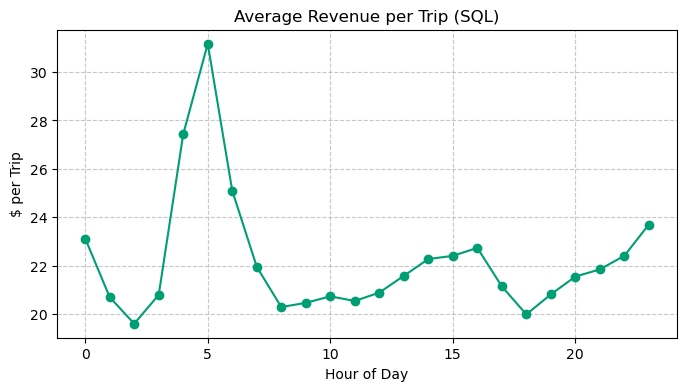

In [23]:
sql_pd = results_sql.toPandas()
plt.figure(figsize=(8,4))
plt.plot(sql_pd["hour"], sql_pd["avg_rev_per_trip"], "o-", color="#009E73")
plt.title("Average Revenue per Trip (SQL)")
plt.xlabel("Hour of Day")
plt.ylabel("$ per Trip")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

## Visual comparison of the 3 employed methods

Comparasion of the execution times of the RDD, DataFrame, and SQL methods by visualizing them in a bar chart.

                             RDD   DataFrame         SQL
Execution time (s)          4.58        0.05        0.13


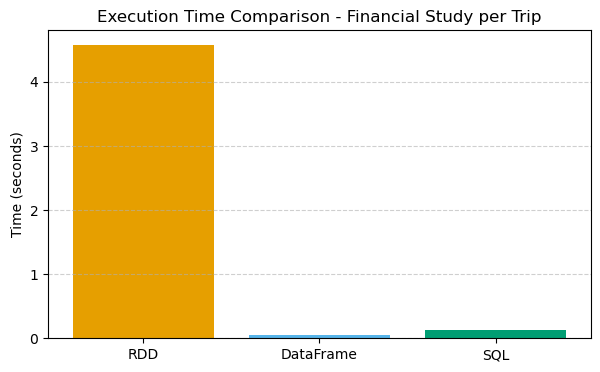

In [24]:
methods = ["RDD", "DataFrame", "SQL"]
times = [t_rdd, t_df, t_sql]
speedups = [times[0] / t for t in times]

header = " " * 20 + "".join(f"{name:>12}" for name in methods)
print(header)
row = f"{'Execution time (s)':<20}" + "".join(f"{t:>12.2f}" for t in times)
print(row)

plt.figure(figsize=(7,4))
plt.bar(methods, times, color=["#E69F00","#56B4E9","#009E73"])
plt.title("Execution Time Comparison - Financial Study per Trip")
plt.ylabel("Time (seconds)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

### Execution Time Analysis
The execution time comparison shows a clear performance difference between the three Spark APIs:
- **RDD** is the slowest, taking approximately 4.58 seconds to complete the aggregation. Its lower-level operations require manual transformations, which adds overhead.
- **DataFrame** executes much faster at around 0.05 seconds, providing both speed and a simpler programming interface.
- **SQL** achieves comparable performance at 0.13 seconds, benefiting from Spark’s automatic query optimizations internally.

These results confirm that higher-level APIs - DataFrame and SQL- deliver the best performance for aggregation-heavy tasks, outperforming RDD by a large margin. 

### Interpretation
The findings highlight the value of using higher-level Spark abstractions. While RDD offers fine-grained control, DataFrame and SQL combine speed, readability, and concise code, making them ideal for large-scale financial analytics where efficiency and maintainability are both critical.

## Measurement of execution times with different numbers of CPU cores

In this step, the execution times with respect to the 3 different implemented methods will be measured for further comparing them and calculating their speedup based on the number of cores employed, following Amdahl's law.

## Measurement of execution times with respect to RDD

Measurement of the execution time of an RDD-based computation (average revenue per hour), using a given number of CPU cores.

In [25]:
def measure_rdd(cores):
    spark = SparkSession.builder.master(f"local[{cores}]").appName(f"AverageSpeedFullAPI-with-{cores}cores").getOrCreate()

    start_time = time.time()
    
    df = read_parquet(spark)
    clean = clean_data(df).withColumn("hour", F.hour("tpep_pickup_datetime")).select("hour", "fare_amount", "tip_amount")
    rdd = financial_rdd(clean)
    
    duration = time.time() - start_time

    stop_session()
    return duration

## Measurement of execution times with respect to DataFrames

Measurement of the execution time of a DataFrame-based computation (average revenue per hour), using a given number of CPU cores.

In [26]:
def measure_df(cores):
    spark = SparkSession.builder.master(f"local[{cores}]").appName(f"AverageSpeedFullAPI-with-{cores}cores").getOrCreate()

    start_time = time.time()
    
    df = read_parquet(spark)
    clean = clean_data(df).withColumn("hour", F.hour("tpep_pickup_datetime")).select("hour", "fare_amount", "tip_amount")
    df = financial_df(clean)
    
    duration = time.time() - start_time

    stop_session()
    return duration


## Measurement of execution times with respect to SQL

Measurement of the execution time of a SQL-based computation (average revenue per hour), using a given number of CPU cores.

In [27]:
def measure_sql(cores):
    spark = SparkSession.builder.master(f"local[{cores}]").appName(f"AverageSpeedFullAPI-with-{cores}cores").getOrCreate()

    start_time = time.time()
    
    df = read_parquet(spark)
    clean = clean_data(df).withColumn("hour", F.hour("tpep_pickup_datetime")).select("hour", "fare_amount", "tip_amount")
    sql = financial_sql(clean)
    
    duration = time.time() - start_time

    stop_session()
    return duration

## Measurement of execution times and computation of speedup

Tests how execution time and speed-up scale with different numbers of CPU cores for RDD, DataFrame, and SQL methods, then prints formatted results.

In [30]:
cores_list = [1, 3, 4, 6]

times_rdd = [measure_rdd(c) for c in cores_list]
times_df  = [measure_df(c) for c in cores_list]
times_sql = [measure_sql(c) for c in cores_list]

speedup_rdd = [times_rdd[0] / t for t in times_rdd]
speedup_df  = [times_df[0]  / t for t in times_df]
speedup_sql = [times_sql[0] / t for t in times_sql]

print("=== Execution Time (seconds) ===")
for c, tr, td, ts in zip(cores_list, times_rdd, times_df, times_sql):
    print(f"{c:>2} cores -> RDD: {tr:>6.2f}s | DataFrame: {td:>6.2f}s | SQL: {ts:>6.2f}s")

print("\n=== Speed-up (T1 / Tp) ===")
for c, sr, sd, ss in zip(cores_list, speedup_rdd, speedup_df, speedup_sql):
    print(f"{c:>2} cores -> RDD: {sr:>5.2f}x | DataFrame: {sd:>5.2f}x | SQL: {ss:>5.2f}x")


=== Execution Time (seconds) ===
 1 cores -> RDD:   8.66s | DataFrame:   0.09s | SQL:   0.09s
 3 cores -> RDD:   4.39s | DataFrame:   0.11s | SQL:   0.07s
 4 cores -> RDD:   4.35s | DataFrame:   0.14s | SQL:   0.08s
 6 cores -> RDD:   4.53s | DataFrame:   0.12s | SQL:   0.15s

=== Speed-up (T1 / Tp) ===
 1 cores -> RDD:  1.00x | DataFrame:  1.00x | SQL:  1.00x
 3 cores -> RDD:  1.97x | DataFrame:  0.79x | SQL:  1.23x
 4 cores -> RDD:  1.99x | DataFrame:  0.62x | SQL:  1.09x
 6 cores -> RDD:  1.91x | DataFrame:  0.71x | SQL:  0.58x


## Visualization

Visualizes the speed-up achieved by RDD, DataFrame, and SQL methods across different core counts, and compares them following Amdahl's Law: $$
    \frac{T(\text{serial} = 1 \text{ core})}{T(\text{parallel} = X \text{ cores})}
    $$

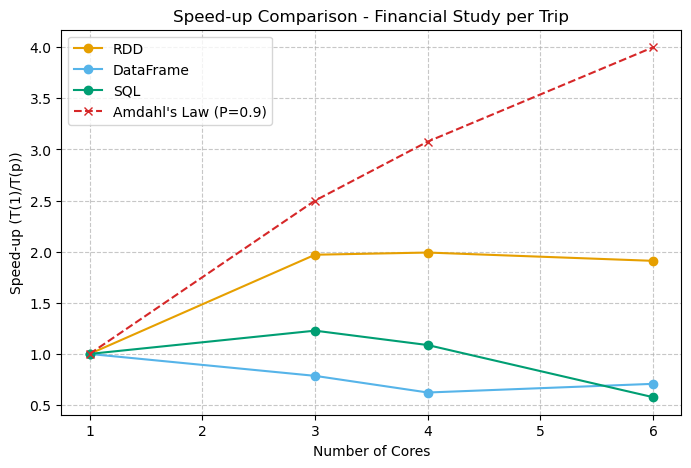

In [31]:
plt.figure(figsize=(8,5))
plt.plot(cores_list, speedup_rdd, 'o-', label="RDD", color="#E69F00")
plt.plot(cores_list, speedup_df, 'o-', label="DataFrame", color="#56B4E9")
plt.plot(cores_list, speedup_sql, 'o-', label="SQL", color="#009E73")

# Amdahl
P = 0.9
cores = np.array(cores_list)
amdahl = 1 / ((1 - P) + (P / cores))
plt.plot(cores, amdahl, 'x--', label="Amdahl's Law (P=0.9)", color="tab:red")

plt.title("Speed-up Comparison - Financial Study per Trip")
plt.xlabel("Number of Cores")
plt.ylabel("Speed-up (T(1)/T(p))")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# Discussion and Final Interpretation

**Financial Analysis:** <br>
Trip revenue varies by hour:

- At midnight (00:00), 65,111 trips generated an average of $22.83 per trip.
- Between 1:00 and 3:00 AM, trips and revenue drop to around $19–20 per trip.
- Around 4:00 AM, average revenue rises to $26.98, likely due to fewer trips and longer distances.

### Performance
- SQL and DataFrame consistently outperform RDD, with execution times around 0.07-0.15 seconds versus RDD’s 4-8.7 seconds.
- RDD’s speed-up improves with more cores (1.9-2x) but remains slower overall, showing limited benefit from parallelization.
- DataFrame and SQL show minimal speed-up with additional cores, as their baseline execution is already very fast; SQL is slightly faster at 3-4 cores, while DataFrame remains stable.
Higher-level APIs (SQL and DataFrame) clearly outperform RDD for aggregation tasks, with only minor differences between them in absolute runtime.

## Suggested Improvement: Task Distribution Optimization
Adjusting partitioning (e.g., using repartition() or coalesce()) could further improve performance for both SQL and DataFrame workflows.

### Final Conclusions 
- SQL delivers the fastest execution overall, especially at 3–4 cores.
- DataFrame maintains stable performance and scales reasonably well, with execution times close to SQL.
- RDD is slower and shows inconsistent speed-up, gaining little from additional cores.
